#### Student Name:
#### Student ID:

# Assignment 5

### VMO / Audio Oracle, Information Rate, Generation by Recombination, Query-based Resynthesis

Instructions: 

* This notebook is a creative assignment; The task is to generate your own musical piece by modifying the code below. Please read the instructions in each cell to follow the production / composition steps.

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook, a printout as a PDF and a WAV file of your raw musical materials and the final musical result.

* Make sure to mark the page with your solution for each problem on Gradescope. Any problems without the correct pages marked may receive a score of 0. 


Variable Markov Oracle (VMO) discovers repetitive structure in time-series. Finding repeated motifs in music is one of its applications. Once the motifs are found, they can be recombined to create new improvisations.

In this assignment we will use the VMO model to construct a recombinant model from a given Saxophone target recording. Then we will use VMO query function to "drive" this model using another sound file. The query sound file will contain an accompaniment part of a song, so the result will be a new saxophone improvisation over that song.

Feel free to BYO files and redo the assignment with music that is fun for you!


### Steps of the music production
The steps of the assignment as specified below include:

* Performing VMO analysis of the target_file recording using several feature options

* Fine tuning the VMO model using Information Rate

* Performing random improvisation from the VMO model

* Creating a query input by feature analysis of the query_file accompaniment

* Performing a query of the VMO model with the accompanimnet feature matrix

* Saving the solo and a mix with the accompaniment

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from __future__ import division
import vmo
import vmo.generate as vge
import librosa
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#### Read the Data
Here we read the Saxophone recording provided on github in the audio folder.

In [122]:
target_file = './audioTestFiles/tenor_sax_13.wav'
samplerate = 22050
y, sr = librosa.load(target_file, sr=samplerate)

## Feature analysis

##### Question 1 [10] 

Choose the appropriate features and analysis parameters

In [204]:
# Chose the parameters
fft_size = 
hop_size = #this defines the overlap. Assime that the window size is same as fft_size

# Hint: the hop size should be sufficient to capture note changes, but should not be too fast. 
# A reasonable time between notes is a several hundred milliseconds. 
# To set up the hop_size calculate the number of samples according to sampling rate. 
# For the sake of efficiency choose number number of samples that is a power of 2.

Extract features from audio file - VMO supports features in arrays directly

In [205]:
# Choose your features. 
# Consider using musically significant feature such as chorma to capture musical structure. 
features = # call to appropriate librosa.feature function

It often helps to process the features to be in log-scale and normalize. Use the next cell at will.

In [206]:
import sklearn.preprocessing as pre
features = np.log(features+np.finfo(float).eps)
features = pre.normalize(features)

##### Question 2 [20]
Listen to the target file and notice musical repetitions or similarly sounding segments. 

Plot the waveform and feature matrix parallel to each other so that the time axis of the two graphs so that they match in time.

Can you observe changes in the waveform and changes in the features at the same time? Find few locations where you can see simultaneous change in both waveform and features and report it.

In [239]:
# Your Code here

``` your response here ```

In [240]:
import IPython.display as ipd
ipd.Audio(y,rate=sr)

VMO: Automatic analysis of repetitive structure using Python
==============================================================



VMO algorithm is based on the Factor Oracle (F0) string matching algorithm that is used to detect repetitions of musical materials. Audio Oracle (AO) was the first application of FO to audio by manually clustering the audio features in order to turn them into symbolic sequence. The main problem in AO is "tuning" the signal-to-symbol method so that its symbolic sequence preserves the maximal amount of information about a original signal.
VMO uses the concept of Information Rate to finetune the signal-to-symbol mappling.

Generative use of VMO: by recombination of repeated motifs according to FO graph, new versions of the analyzed work can be created. VMO aims to be a toolbox for exploring this type of automated musical analysis and generation.

VMO has applications for:

+ automated music analysis
+ algorithmic composition
+ machine improvisation

VMO makes it easy to experiment with Oracle structures

VMO requires a threshold to determine when approximate repetitions are similar enough to be used for recombination. This is done automatically by finding a threshold with highest information rate. Run the following cells to see the IR plot and read about the IR calculation.

Note: the dimensions of features input into vmo is a matrix (time,features), so it is transposed to librosa output. The dim parameter is thus the shape of axis 0.

In [241]:
r = (0.0, 1.0, 0.01) 
ideal_t = vmo.find_threshold(features.T, r = r, flag = 'a', dfunc = 'euclidean', dim=features.shape[0])

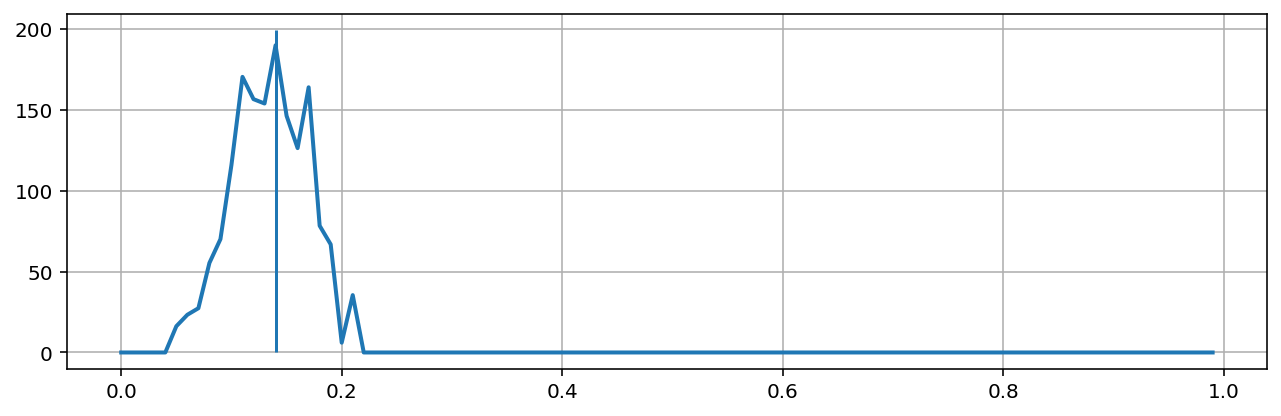

In [242]:
x_t = np.array([t[1] for t in ideal_t[1]])
y_t = [t[0] for t in ideal_t[1]] 
plt.figure(figsize = (9,3))
plt.plot(x_t, y_t, linewidth = 2)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t[0][1], 0, ymax)
plt.grid('on')
plt.tight_layout()

Information Rate
====

Information Rate (IR) is a measure of the reduction in uncertainty about the present given what we know about the past, and is defined as the difference between the unconditional complexity of $x$ and the conditional complexity of $x_n$ given $x_{past}$:

$$ IR(x_{past}, x_n) = C(x_n) - C(x_n | x_{past}) $$

where 

$$ C(\cdot) $$ 

is a compressed version of the oracle and is used to estimate the complexity. It is possible to have multiple suffixes which are varying lengths of the same pattern. We can compress the oracle by keeping only the longest repeated suffixes. The longest repeated suffix (LRS) of a state is the longest suffix of the prefix to a state $i$ that appears at least twice in the prefix. I.e. the longest sequence of states leading up to $i$ that appears at least twice before $i$.

Compression in AO is as follows:

1. We first need the size of the 'alphabet' - this is straight-forward in the symbolic FO, but in AO we use the number of transitions from state 0. Each transition from 0 corresponds to a new state. The number of unique states = size of the alphabet.
2. The number of bits needed to encode that set is $log2(# of transitions from 0)$. This is used as a measure of unconditional complexity, giving us: $C(x_n)$
3. An array $K = [1]$ of encoding events is generated:
    1. If no repetition of $i$ is found, then $sfx(i) = 0$ . This is a new frame, and will need to be individually encoded. It is added to $K$
    2. Otherwise, if a suffix link to an earlier state is found, and the LRS < the number of states since the last encoding event, the entire segment is encoded as $(length, position)$.
4. Using $K$, we can determine $C(x_n|x_{past})$. For every state i, # bits required to represent the state = # bits required to represent the pair (length, position) / length of encoded block.
$$ C(x_n|x_{past}) = \frac{log_2(N) + log_2(M)}{K(i+1) - K(i)} $$ where $M = max(LRS){ }$  and $N$ is sequence length.

Code is an indication of the compressed version of the oracle. Each tuple indicates the number and source of repetitions.

#### Optimal Oracle:
So now, in theory, this threshold will give us the best oracle.

In [243]:
# best threshold is
print(ideal_t[0])
t = ideal_t[0][1]

(189.73766099191758, 0.14)


Building an audio oracle:
--

vmo.build_oracle() takes arguments for:

* the complete feature vector from the feature extractor
* a threshold value for the distance function
* a string indicating the feature to build the oracle on
* an optional number of feature frames to average

In [244]:
best_oracle = vmo.build_oracle(features.T, flag = 'a',
                          threshold = t,
                          feature = 'chroma', dfunc = 'euclidean', dim=features.shape[0])

Now we can plot the IR graph:

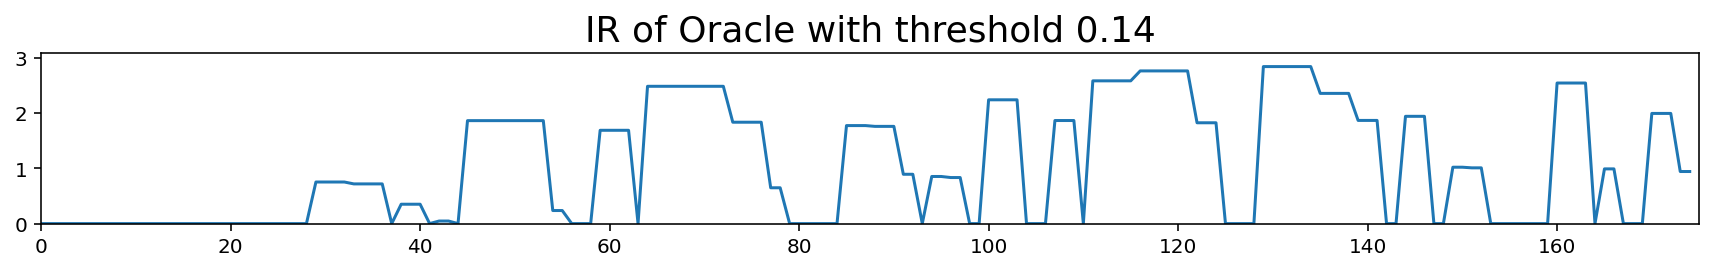

In [245]:
ir, h0, h1 = best_oracle.IR()
plt.figure(figsize=(12,2))
plt.plot(ir)
plt.ylim((0, max(ir) + 0.25))
plt.xlim((0, len(ir)))
plt.title('IR of Oracle with threshold' + ' ' + str(t), fontsize=18)
plt.tight_layout()

The IR graph shows the instantenous compression factor at every point along the sequence. 

High IR means that a link was found to a long past sequence that allows efficient encoding of the current motif by recopying it from the past. Low IR means that a new sequence appeared that cannot be encoded based on the past.

##### Question 3 [10]

Compare the IR graph to the previous feature and signal plots. Can you see a correspondence between event in the features and changes in the IR? How does IR correspond to the structure of the signal? 

You may add a new cell and recopy all three plots with matching time axis, or plot IR on top of the features to see when significant changes occur.

``` Your response here ```

Structure of the Audio Oracle
=============
VMO implements the *Audio Oracle* (AO) algorithm, which is based on the *Factor Oracle* (FO) string matching structure proposed by Allauzen et al. FO is an acyclic automaton which recognizes all substrings ("factors") in a given string. FO will also sometimes recognize factors which are not part of the original string, but this is not a problem for our application. The structure can be built in an online fashion, i.e. character-by-character, and allows for efficient substring searches. 

 - *Forward transitions* (upper arcs in figures) from state 0 indicate the appearance of a new character, while forward transitions from other states indicate the appearance of sub-factors. 

- *Suffix links* (lower arcs) point backward to the occurence of repeated patterns. The connected states share some common context. The length of the repeated suffix (LRS) is not indicated in this visualization.

So, navigating this oracle structure allows generation of new patterns which inherit some of the motif structure of the original sequence. Traveling along forward transitions gives us subfactors (sometimes false) of the original sequence, which jumping back along suffixes allows for creation of new sequences which share a common context.


In [246]:
from vmo.plot import start_draw
img = start_draw(best_oracle, size=(1600, 400))
print(img)

<PIL.Image.Image image mode=RGB size=1600x400 at 0x15FE2CF60>


Text(0.5, 1.0, 'Oracle Structure')

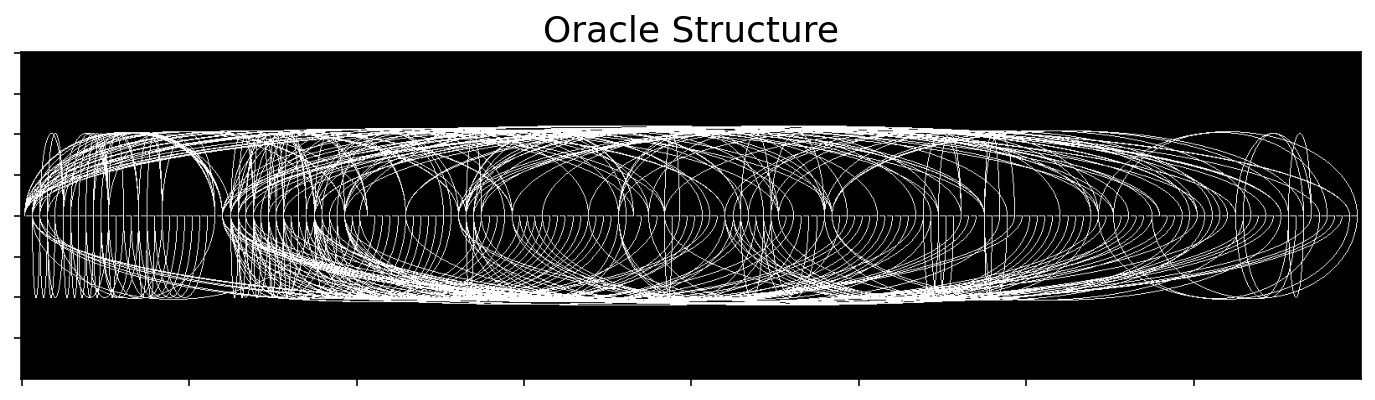

In [247]:
plt.figure(figsize=(12,3))
f = plt.gca()
plt.imshow(np.asarray(img), aspect = 'auto')
f.axes.xaxis.set_ticklabels([])
f.axes.yaxis.set_ticklabels([])
plt.title('Oracle Structure', fontsize = 18)

##### Question 4 [20]

Explain how the visual structure of the Oracle depends on the threshold. Using the code for the best_oracle, modify it to create oracles with low and high values of threshold. Plot the graphs and explain what you see.

In [248]:
# Your code here

``` your response here```

Recomposing / Recombining music using VMO
====

VMO can be used to create a random improvisation from the target file. To generate new output, the oracle is navigated state-by-state, and either continues linearly (with probability *p*) or jumps along a transition / suffix link (*1-p*).

In [249]:
help(vge.generate)

Help on function generate in module vmo.generate:

generate(oracle, seq_len, p=0.5, k=1, LRS=0, weight=None)
    Generate a sequence based on traversing an oracle.
    
    :param oracle: a indexed vmo object
    :param seq_len: the length of the returned improvisation sequence
    :param p: a float between (0,1) representing the probability using the forward links.
    :param k: the starting improvisation time step in oracle
    :param LRS: the length of minimum longest repeated suffixes allowed to jump
    :param weight:
            None: choose uniformly among all the possible sfx/rsfx given
                current state.
            "max": always choose the sfx/rsfx having the longest LRS.
            "weight": choose sfx/rsfx in a way that favors longer ones than
            shorter ones.
    :return:
            s: a list containing the sequence generated, each element represents a
            state.
            kend: the ending state.
            ktrace:



In [250]:
ln = 1000 #Enter here the duration of output file in frames
s, _kend, _ktrace = vge.generate(best_oracle, ln, p=0.5, k=1, LRS=2, weight='weight')
vge.audio_synthesis(target_file, 'out1.wav', s, sr, fft_size, hop_size)

(array([8.8174124e-07, 9.0439261e-07, 9.9374518e-07, ..., 2.6324182e-07,
        2.7656645e-07, 3.0386130e-07], dtype=float32),
 array([1.00000000e-05, 1.00367716e-05, 1.01470865e-05, ...,
        1.01470865e-05, 1.00367716e-05, 1.00000000e-05]),
 22050)

##### Question 5 [10] 
Try improvising with several values of p and lrs parameters. Save the results with meaningful name, such as out_1_p#_lrs# with corresponding p and lrs values. Report what you hear in terms of the different musical qualities: How does low versus high p differ? What happens if the lrs is relatively long? Can you explain why long lrs value does not produce much variation?

``` Your response here ```

## Query based Resynthesis

Instead of random improvisation, the navigation of the oracle can be done in a way that matches a seqeunce of features from a query sound. In this section we will conduct such an experiment.

In [251]:
import vmo.analysis as van

In [252]:
qfilename = './audioTestFiles/Jazz_C2.wav'
z, sr = librosa.load(qfilename, sr=samplerate)

In [253]:
import IPython.display as ipd
ipd.Audio(z,rate=sr)

##### Question 6 [10]
Perform same type of analysis on the query file. Plot the query features.

In [254]:
# Your Code Here

The next command queries the oracle with the query features to find possible paths. The optimal path is given by the i_hat parmeter

In [255]:
path, cost, i_hat = van.query(best_oracle, query_features.T)

Now we can resynthesize the target using the optimal path

In [256]:
vge.audio_synthesis(target_file, 'out2.wav', path[i_hat], samplerate, fft_size, hop_size)

(array([-4.3838233e-07, -5.4095744e-07, -5.8069361e-07, ...,
        -3.3484312e-07, -3.2072660e-07, -3.1080910e-07], dtype=float32),
 array([1.00000000e-05, 1.00367716e-05, 1.01470865e-05, ...,
        1.01470865e-05, 1.00367716e-05, 1.00000000e-05]),
 22050)

In [257]:
import IPython.display as ipd
ipd.Audio('out2.wav')

##### Question 7 [20]
Final Mix: Add both the output improvisation and the query into one file. You can do this outside of python, such as open it in audacity as separate tracks and save them into one mixed file or put them in separate tracks for stereo. Save and sumbit the mix.

#### Note of advice: 
Now when you are done with the whole process, try repeating it with different frame size (fft_lentgh and hope_length). Find one that sounds good to you and submit the best result!